Weighted Average Beam Diameter at 5.08 cm: 0.0601 cm


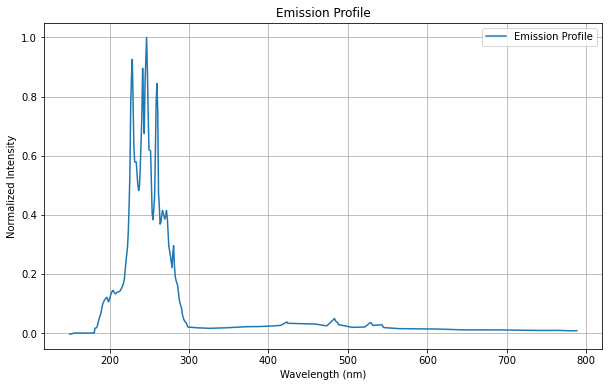

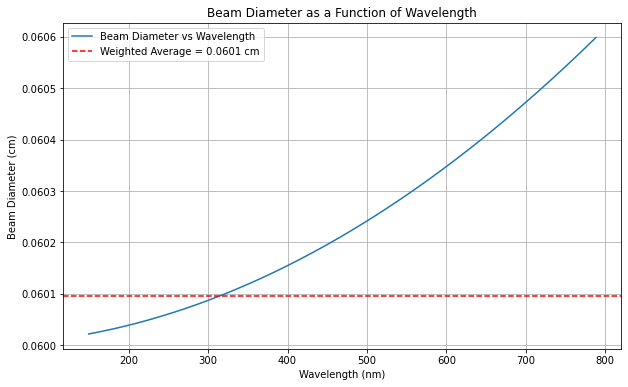

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Given parameters
fiber_diameter = 0.06  # in cm
numerical_aperture = 0.22
initial_distance = 5.08  # in cm

# Example emission profile (replace with actual data)
wavelengths, intensities = pickle.load(open('/home/sam/sw/chroma-lxe/data/xe-spectrum.p', 'rb'))
# nm to cm
wavelengths = wavelengths * 1E-7

# Normalize intensities
intensities /= np.max(intensities)



# Calculating the divergence angle in radians (constant for all wavelengths)
theta = np.arcsin(numerical_aperture)

# Beam waist
w_0 = fiber_diameter / 2

# Function to calculate beam diameter at a given distance for a specific wavelength
def beam_diameter(distance, fiber_diameter, wavelength):
    w_0 = fiber_diameter / 2
    return 2 * w_0 * np.sqrt(1 + (wavelength * distance / (np.pi * w_0**2))**2)

# Calculate beam diameters for all wavelengths at the initial distance
beam_diameters = np.array([beam_diameter(initial_distance, fiber_diameter, wl) for wl in wavelengths])

# Calculate the weighted average beam diameter
weighted_beam_diameter = np.sum(beam_diameters * intensities) / np.sum(intensities)

# Print the weighted average beam diameter
print(f'Weighted Average Beam Diameter at {initial_distance} cm: {weighted_beam_diameter:.4f} cm')

# Plot the emission profile
plt.figure(figsize=(10, 6))
plt.plot(wavelengths * 1e7, intensities, label='Emission Profile')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.title('Emission Profile')
plt.grid(True)
plt.legend()
plt.show()

# Plot the beam diameters as a function of wavelength
plt.figure(figsize=(10, 6))
plt.plot(wavelengths * 1e7, beam_diameters, label='Beam Diameter vs Wavelength')
plt.axhline(y=weighted_beam_diameter, color='r', linestyle='--', label=f'Weighted Average = {weighted_beam_diameter:.4f} cm')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Beam Diameter (cm)')
plt.title('Beam Diameter as a Function of Wavelength')
plt.grid(True)
plt.legend()
plt.show()


In [296]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import jn
from scipy.interpolate import interp1d

%matplotlib inline

# Given parameters
fiber_diameter = 0.06  # in cm
numerical_aperture = 0.22
num_photons = 100000

# Calculate cumulative distribution function (CDF) for sampling wavelengths
cdf = np.cumsum(intensities)
cdf /= cdf[-1]

# Function to sample wavelengths based on the emission profile
def sample_wavelengths(cdf, wavelengths, num_samples):
    random_values = np.random.rand(num_samples)
    sampled_wavelengths = np.interp(random_values, cdf, wavelengths)
    return sampled_wavelengths

def bessel_intensity_profile(r, a, offset=0.02):
    return np.abs(jn(5, r * 8.5 / a))**2

# Function to sample positions based on Gaussian intensity profile
def sample_positions_gaussian(num_samples, fiber_diameter):
    w_0 = fiber_diameter / 2
    U = np.random.rand(num_samples)
    r = w_0 * np.sqrt(-np.log(U)/2)
    r = r[r <= w_0]  # Ensure radii are within the fiber core
    theta = 2 * np.pi * np.random.rand(len(r))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros(len(r))  # Initial z positions at the fiber end
    return np.stack((x, y, z), axis=-1)

def sample_positions_bessel(num_samples, fiber_radius):
    r = np.linspace(0, fiber_radius, 1000)
    intensity = bessel_intensity_profile(r, fiber_radius)
    cdf_intensity = np.cumsum(intensity)
    cdf_intensity /= cdf_intensity[-1]
    
    # Invert CDF to sample radial positions
    random_values = np.random.rand(num_samples)
    interp_r = interp1d(cdf_intensity, r, fill_value='extrapolate', bounds_error=False)
    sampled_r = interp_r(random_values)
    
    theta = 2 * np.pi * np.random.rand(num_samples)
    x = sampled_r * np.cos(theta)
    y = sampled_r * np.sin(theta)
    z = np.zeros(num_samples)  # Initial z positions at the fiber end
    return np.stack((x, y, z), axis=-1)


# Sample initial positions
positions = sample_positions_bessel(num_photons, fiber_diameter/2)

# Sample initial directions based on the numerical aperture
divergence_angle = np.arcsin(numerical_aperture)

# Generate random angles for direction vectors within the allowed divergence cone
phi = 2 * np.pi * np.random.rand(num_photons)  # Azimuthal angle
theta = divergence_angle * np.sqrt(np.random.rand(num_photons))  # Polar angle scaled by divergence angle

# Convert spherical coordinates to Cartesian coordinates for direction
directions = np.stack((
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    np.cos(theta)
), axis=-1)

# Normalize directions to unit vectors
directions /= np.linalg.norm(directions, axis=1)[:, np.newaxis]

# Sample initial wavelengths
initial_wavelengths = sample_wavelengths(cdf, wavelengths, num_photons)

# Sample initial polarizations (random polarization states)
polarizations = np.random.uniform(0, 2 * np.pi, num_photons)

# Combine all data into a structured array
photons = np.zeros(num_photons, dtype=[('position', float, 3), ('direction', float, 3),
                                       ('wavelength', float), ('polarization', float)])
photons['position'] = positions
photons['direction'] = directions
photons['wavelength'] = initial_wavelengths
photons['polarization'] = polarizations

# Visualization of photon positions and directions
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=initial_wavelengths * 1e7, cmap='viridis', s=2)
# # plot circle with diameter of fiber
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)
# x = fiber_diameter / 2 * np.outer(np.cos(u), np.sin(v))
# y = fiber_diameter / 2 * np.outer(np.sin(u), np.sin(v))
# z = np.zeros_like(x)
# # ax.plot_surface(x, y, z+0.0001, color='r', alpha=1)
# quiver = ax.quiver(positions[:, 0], positions[:, 1], positions[:, 2], directions[:, 0], directions[:, 1], directions[:, 2], length=0.1, color='red', alpha=0.05)
# plt.colorbar(scatter, label='Wavelength (nm)')
# ax.set_xlabel('Position X (cm)')
# ax.set_ylabel('Position Y (cm)')
# ax.set_zlabel('Position Z (cm)')
# plt.title('Initial Photon Distribution in 3D with LP01 Mode Intensity Profile')
# plt.show()

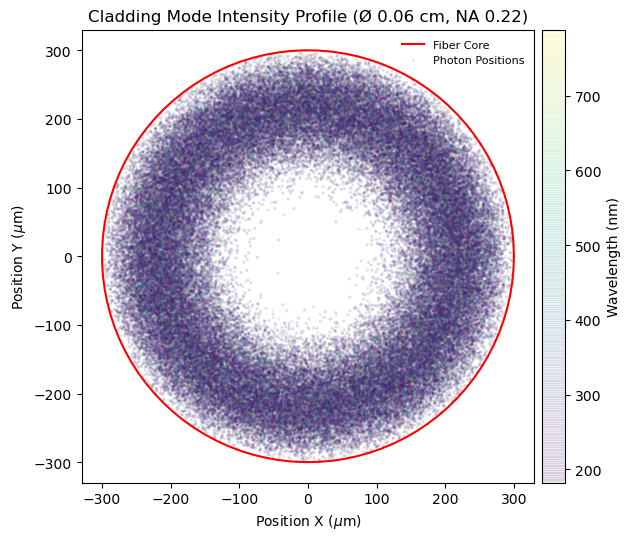

In [294]:
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(positions[:,0] * 10000, positions[:,1] * 10000, c=initial_wavelengths * 1e7, cmap='viridis', s=2, label='Photon Positions', alpha=0.1)

# plot circle with diameter of fiber
u = np.linspace(0, 2 * np.pi, 100)
x = fiber_diameter / 2 * np.cos(u)
y = fiber_diameter / 2 * np.sin(u)
plt.plot(x * 10000, y * 10000, 'r', label='Fiber Core')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label='Wavelength (nm)', pad=0.01)
plt.xlabel('Position X ($\\mu$m)')
plt.ylabel('Position Y ($\\mu$m)')
plt.title('Cladding Mode Intensity Profile (Ø 0.06 cm, NA 0.22)')
plt.legend(frameon=False, fontsize=8)
plt.show()

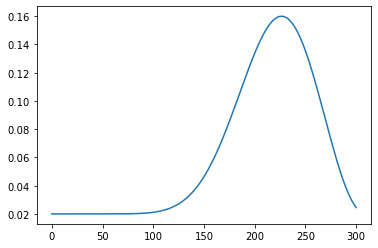

In [252]:
fiber_radius = 300
r = np.linspace(0, fiber_radius, 1000)
intensity = bessel_intensity_profile(r, fiber_radius) + 0.02
cdf_intensity = np.cumsum(intensity)
cdf_intensity /= cdf_intensity[-1]

plt.plot(r, intensity, label='Intensity Profile')

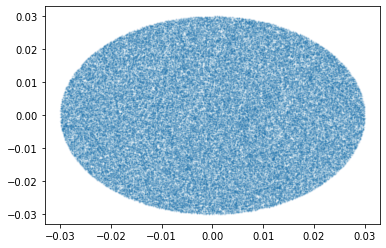

In [285]:
r = np.linspace(0, fiber_radius, 1000)
intensity = 1/(r+1e-10)
cdf_intensity = np.cumsum(intensity)
cdf_intensity /= cdf_intensity[-1]

random_vals=  np.random.rand(100000)
interp_r = interp1d(cdf_intensity, r, fill_value='extrapolate', bounds_error=False)
sampled_r = interp_r(random_vals)

sampled_r = np.sqrt(random_vals) * fiber_radius

# plt.hist(sampled_r, bins=100, density=True, alpha=0.6, label='Sampled Radii')
theta = 2 * np.pi * np.random.rand(100000)
x = sampled_r * np.cos(theta)
y = sampled_r * np.sin(theta)

plt.scatter(x, y, s=1, alpha=0.1, label='Sampled Positions')
plt.show()

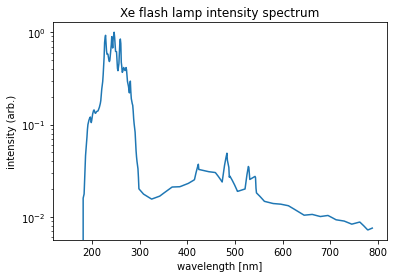

In [86]:
plt.plot(wavelengths * 1e7, intensities)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity (arb.)')
plt.title('Xe flash lamp intensity spectrum')
plt.yscale('log')
plt.show()

<ipython-input-209-ea11690c0c45>:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x, y, np.abs(mode_profile)**2 + 0.02, shading='auto', cmap='rainbow', norm=plt.Normalize(0,))


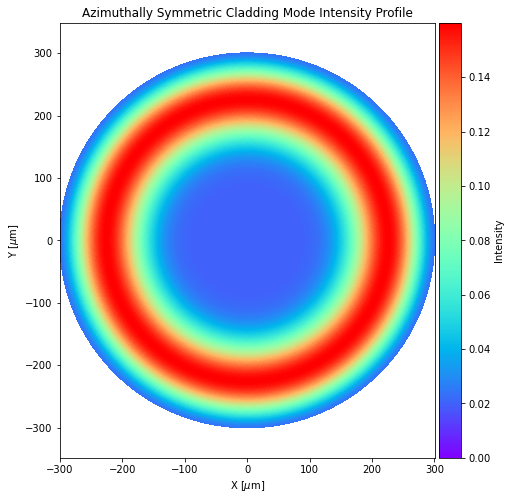

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn, yn
from matplotlib.colors import LogNorm

# Define parameters
k_r = 1.9e-2  # radial component of the wave vector
n = 5  # azimuthal mode number

# Create a grid of points in cylindrical coordinates
r = np.linspace(0, 300, 400)
phi = np.linspace(0, 2*np.pi, 400)
r, phi = np.meshgrid(r, phi)

# Calculate the radial component
radial_component = jn(n, 8.5 * r / 300)

# Combine components to get the mode profile
mode_profile = radial_component

# Convert to Cartesian coordinates for plotting
x = r * np.cos(phi)
y = r * np.sin(phi)

# Plot the cladding mode intensity profile
plt.figure(figsize=(8, 8))
plt.pcolormesh(x, y, np.abs(mode_profile)**2 + 0.02, shading='auto', cmap='rainbow', norm=plt.Normalize(0,))
plt.colorbar(label='Intensity', pad=0.01)
plt.title('Azimuthally Symmetric Cladding Mode Intensity Profile')
plt.xlabel('X [$\\mu$m]')
plt.ylabel('Y [$\\mu$m]')
plt.axis('equal')
plt.show()


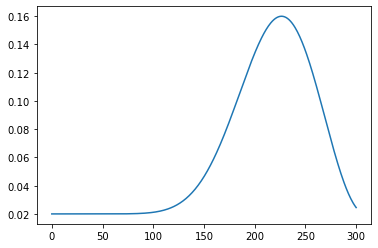

In [218]:
plt.plot(r[0], np.abs(mode_profile[0])**2 + 0.02);

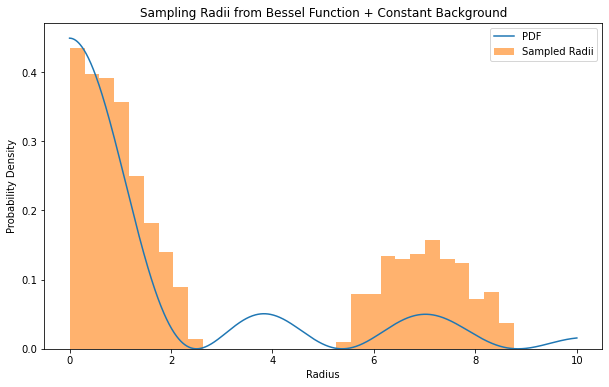

In [287]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

def bessel_pdf(r, nu, b, R_max):
    """Probability density function combining Bessel function of the first kind and constant background."""
    bessel_term = sp.jn(nu, r)
    background_term = b / R_max
    return bessel_term + background_term

def normalize_pdf(pdf, r_values):
    """Normalize the PDF so it integrates to 1 over the range of r_values."""
    normalization_constant = np.trapz(pdf, r_values)
    return pdf / normalization_constant

def rejection_sampling(pdf, r_values, num_samples):
    """Perform rejection sampling to sample from the given PDF."""
    pdf_max = np.max(pdf)
    samples = []
    while len(samples) < num_samples:
        r = np.random.uniform(0, r_values[-1])
        u = np.random.uniform(0, pdf_max)
        if u < pdf[np.searchsorted(r_values, r)]:
            samples.append(r)
    return np.array(samples)

# Parameters
nu = 0  # Order of the Bessel function
b = 0.5  # Background constant
R_max = 10  # Maximum radius
num_samples = 1000  # Number of samples to draw
r_values = np.linspace(0, R_max, 1000)

# Compute the PDF values
pdf_values = bessel_pdf(r_values, nu, b, R_max)

# Normalize the PDF
normalized_pdf = normalize_pdf(pdf_values, r_values)

# Sample radii using rejection sampling
samples = rejection_sampling(normalized_pdf, r_values, num_samples)

# Plot the PDF and the sampled radii histogram
plt.figure(figsize=(10, 6))
plt.plot(r_values, normalized_pdf**2, label='PDF')
plt.hist(samples, bins=30, density=True, alpha=0.6, label='Sampled Radii')
plt.xlabel('Radius')
plt.ylabel('Probability Density')
plt.title('Sampling Radii from Bessel Function + Constant Background')
plt.legend()
plt.show()
